# Base CNN Model Training

## Notebook Context

This Default CNN will be the 'minimum required functionality' design - just small enough to make predictions without overfitting to its own training data (when comparing validation and training loss)


The metrics that will be logged throughout all experiments will be training loss, validation loss, and prediction loss and accuracy. The parameters and factors logged will be the number of epochs, the layers, the batch size, the normalization and pruning used (if applicable) and the datasets used and their characteristics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [ ]:
#Mount Data Folder From Google Drive:
path = "./GenTrack5Throttle/"
pathEval2 = "./WH5Throttle/"
pathEval1 = "./DefRoad5Throttle/"

In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/GenTrack5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/DefRoad5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/WH5Throttle.zip'

In [ ]:
#Import required packages for this step:
%tensorflow_version 1.x
import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

TensorFlow 1.x selected.


In [ ]:
#Read data from files into corresponding lists
%%time

im_list = [] #initialise list of images

rec_list = [] #initialise list of records

#Read relevant files into relevant lists

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

print(len(im_list))
print(len(rec_list))

15995
15995
CPU times: user 12.5 ms, sys: 18.9 ms, total: 31.4 ms
Wall time: 32.9 ms


(15995, 120, 160, 3)
(15995,)
(15995,)
0.03773144
0.05


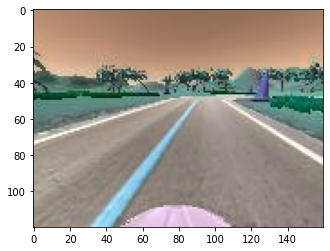

CPU times: user 6.84 s, sys: 2.48 s, total: 9.32 s
Wall time: 9.33 s


In [ ]:
%%time

#Import Image from Pillow
from PIL import Image

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:

x_images = np.zeros((len(rec_list), width, height, color), dtype = np.float32)

print(x_images.shape)
#Read images into images array
for i in range(len(im_list)):
    filename = im_list[i]
    image = cv2.imread(path+filename)
    #x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x_images[i,:,:,:] = image
    
#read angle labels into y_angle array
json_data = {}
y_angle = np.zeros(len(rec_list), dtype=np.float32) #setup label array 
print(y_angle.shape)
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_angle[i] = orient

#read throttle labels into y_throttle array
y_throttle = np.zeros(len(rec_list), dtype=np.float32) #setup label array 
print(y_throttle.shape)
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        vroom = json_data['user/throttle']
        y_throttle[i] = vroom

randomImage = randrange(len(x_images)) #Get an index for a random image to show to ensure data read correctly
print(y_angle[randomImage])
print(y_throttle[randomImage])
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show() #Show Image

In [ ]:
#Donkey Training and Val data splits
def train_test_split(data_list,label_list, label2_list, shuffle=True, test_size=0.2):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    label2_list = list(label2_list)
    train_data = []
    traina_labels =[]
    traint_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        traina_labels.append(label_list.pop(i_choice))
        traint_labels.append(label2_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    vala_labels = label_list
    valt_labels = label2_list
    return val_data, train_data, vala_labels, traina_labels, valt_labels, traint_labels

x_val, x_train, y_vala, y_traina, y_valt, y_traint = train_test_split(x_images,y_angle, y_throttle)

print(len(x_val)/len(x_images))

plt.imshow(x_train[1000].astype('uint8'))
plt.show()
print(y_traina[1000])
print(y_traint[1000])
x_val = np.asarray(x_val)/255 #Images best practices
y_vala = np.asarray(y_vala)
y_valt = np.asarray(y_valt)
x_train = np.asarray(x_train)/255
y_traina = np.asarray(y_traina)
y_traint = np.asarray(y_traint)


plt.imshow(x_train[1000])
plt.show()

NameError: ignored

### Step 2: Set up Experiment and Train Network


In [ ]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [ ]:

#Neptune experiment initialization:
try:
   import neptune
except:
  !pip install neptune-client
  import neptune
#Import neptune and initialise tracking of an experiment

  neptune.init(
      api_token=None,
      project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected


#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)


#Experiment Parameters:

OPTIMIZER = 'adam' #stochastic gradient descent
LOSS = 'mse' #absolute error from the value desired
#LOSS = 'mae'
EPOCH = 300
BATCH = 132
KERNEL1 = 5
KERNEL2 = 3
STRIDE = 2
CONVLAYERS = 6
DENSELAYERS = 4
POOLLAYERS = 1
PRUNING = "dropout"

In [ ]:
#Start Experiment:
neptune.create_experiment(name='Base CNN Train',
                          params={'epochs': EPOCH,
                                  'batch_size': BATCH,
                                  'Convolutional Layers': CONVLAYERS,
                                  'Dense Layers': DENSELAYERS,
                                  'Pooling Layers': POOLLAYERS,
                                  'Optimization' : OPTIMIZER,
                                  'LOSS': LOSS},         
                          tags=['Base_CNN_Train', 'Dropout', 'Model_Logged'],
                          description="Training for final Base CNN Architecture. Model logged as artifact."
                          )


https://ui.neptune.ai/charag/Littlefoot/e/LIT-172


Experiment(LIT-172)

In [ ]:
%tensorflow_version 1.x
import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, Convolution1D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda


In [ ]:
#Model Structure Setup:
drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(32, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = MaxPooling2D(3,1,padding='valid')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(128, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = Dense(500, activation='relu')(x)
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
import keras.backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def perc_acc(y_true, y_pred):
    return K.mean(((y_true+0.00001-y_pred)/(y_true+0.00001))*100)

#Compile Model 
model.compile(optimizer=OPTIMIZER,
    loss=LOSS)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 79, 12)   336         img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 29, 39, 24)   2616        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 29, 39, 24)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Using TensorFlow backend.


In [ ]:
#Fit Model to Data
modelname = 'DefaultCNN_LIT-172.h5'
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_n_outputs0_loss', patience=50)
save_best = keras.callbacks.ModelCheckpoint(modelname, monitor='val_n_outputs0_loss', verbose=1, save_best_only=True, mode='min')
#model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)


model.fit(x_train, [y_traina, y_traint], epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, [y_vala, y_valt]),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)
neptune.log_artifact(modelname)
neptune.stop()

## STEP 3: Validate Model
After the experiment has completed, select a random image/label pair with which to run a prediction, or even a set of these predictions, to have a tangible vision of how the model performs.

In [ ]:
#Load up some alternative validation datasets:
x_val_1_list = []  #Images for validation set 1
y_val_1_list = []  #Labels for validation set 1
x_val_2_list = []  #Images for validation set 2
y_val_2_list = []  #Labels for validation set 2

for file in os.listdir(pathEval1):
    if 'cam' in file:
        x_val_1_list.append(file)
    elif 'record' in file:
        y_val_1_list.append(file)


for file in os.listdir(pathEval2):
    if 'cam' in file:
        x_val_2_list.append(file)
    elif 'record' in file:
        y_val_2_list.append(file)

x_val_1_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
y_val_1_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

x_val_2_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
y_val_2_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple


x1_images = np.zeros((len(y_val_1_list), width, height, color), dtype = np.float32)
x2_images = np.zeros((len(y_val_2_list), width, height, color), dtype = np.float32)

print(x1_images.shape)
print(x2_images.shape)
#Read images into images array
for i in range(len(x_val_1_list)):
    filename = x_val_1_list[i]
    image = cv2.imread(pathEval1+filename)
    #x1_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x1_images[i,:,:,:] = image

for i in range(len(x_val_2_list)):
    filename = x_val_2_list[i]
    image = cv2.imread(pathEval2+filename)
    #x2_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x2_images[i,:,:,:] = image

#read angle labels into y_labels array
json_data = {}
y1_labels = np.zeros(len(y_val_1_list), dtype=np.float32) #setup label array 
y1_labelst = np.zeros(len(y_val_1_list), dtype=np.float32) #setup label array 
y2_labels = np.zeros(len(y_val_2_list), dtype=np.float32) #setup label array 
y2_labelst = np.zeros(len(y_val_2_list), dtype=np.float32) #setup label array 


print(y1_labels.shape)
print(y2_labels.shape)


for i in range(len(y_val_1_list)):
    filename = y_val_1_list[i]
    with open(pathEval1+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y1_labels[i] = orient
        vroom = json_data['user/throttle']
        y1_labelst[i] = vroom

for i in range(len(y_val_2_list)):
    filename = y_val_2_list[i]
    with open(pathEval2+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y2_labels[i] = orient
        vroom = json_data['user/throttle']
        y2_labelst[i] = vroom

x1_val, _, y1_vala, _, y1_valt,_ = train_test_split(x1_images,y1_labels, y1_labelst)
x2_val, _, y2_vala, _ ,y2_valt, _= train_test_split(x2_images,y2_labels, y2_labelst)


x1_val = np.asarray(x1_val)/255 #Images best practices
y1_vala = np.asarray(y1_vala)
y1_valt = np.asarray(y1_valt)
x2_val = np.asarray(x2_val)/255
y2_vala = np.asarray(y2_vala)
y2_valt = np.asarray(y2_valt)



(17100, 120, 160, 3)
(13060, 120, 160, 3)
(17100,)
(13060,)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Evaluation for Generated Road Data:


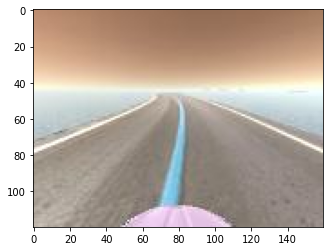

Label:
-0.05585181
3420/3420 [==============================] - 1s 246us/sample - loss: 0.0410 - n_outputs0_loss: 0.0410 - n_outputs1_loss: 5.2461e-06
[[0.05235356]
 [0.0540416 ]
 [0.0542964 ]
 ...
 [0.0519413 ]
 [0.05057185]
 [0.05270841]]
(2, 3420)
result:
0.12189614
0.050120775
0.16446154575647884
0.5391732835992346
0.46082671640076545
Model Evaluation for Warehouse Data


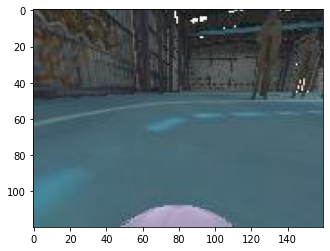

Label:
0.2774029
2612/2612 [==============================] - 1s 201us/sample - loss: 0.0496 - n_outputs0_loss: 0.0487 - n_outputs1_loss: 8.9630e-04
[[0.04947821]
 [0.04716044]
 [0.04487916]
 ...
 [0.04895109]
 [0.05315747]
 [0.05074326]]
(2, 2612)
result:
-0.12197388
0.04571484
0.17769999593099833
0.7772676700204906
0.22273232997950942


In [ ]:
modelname = 'DefaultCNN_LIT-172.h5'
BATCH = 132

ModelBest = keras.models.load_model(modelname)
"""
num = randrange(len(x_val))

#Select Random Image and Label to show as examples
plt.imshow(x_val[num])
plt.show()

pred_im = x_val[num]
pred_label = y_vala[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_vala))
perc = np.zeros(len(y_vala))


#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_val, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_val, [y_vala, y_valt], batch_size=BATCH, verbose=1)
print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y_vala)):
  diff[i] = abs(y_vala[i] - label_out[0,i])
  perc[i] = (np.max(y_vala)-diff[i])/np.max(y_vala)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))
"""

print("Evaluation for Generated Road Data:")
num = randrange(len(x1_val))

#Select Random Image and Label to show as examples
plt.imshow(x1_val[num])
plt.show()

pred_im = x1_val[num]
pred_label = y1_vala[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y1_vala))
perc = np.zeros(len(y1_vala))

#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x1_val, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x1_val, [y1_vala, y1_valt], batch_size=BATCH, verbose=1)
print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y1_vala)):
  diff[i] = abs(y1_vala[i] - label_out[0,i])
  perc[i] = (np.max(y1_vala)-diff[i])/np.max(y1_vala)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))

print("Model Evaluation for Warehouse Data")

num = randrange(len(x2_val))

#Select Random Image and Label to show as examples
plt.imshow(x2_val[num])
plt.show()

pred_im = x2_val[num]
pred_label = y2_vala[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y2_vala))
perc = np.zeros(len(y2_vala))


#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x2_val, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x2_val, [y2_vala, y2_valt], batch_size=BATCH, verbose=1)
print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y2_vala)):
  diff[i] = abs(y2_vala[i] - label_out[0,i])
  perc[i] = (np.max(y2_vala)-diff[i])/np.max(y2_vala)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))